In [7]:
import math, sys, os, torch, torchvision
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

print("CUDA version:", torch.version.cuda)



Using gpu: True 
CUDA version: 11.8


Feature batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4])


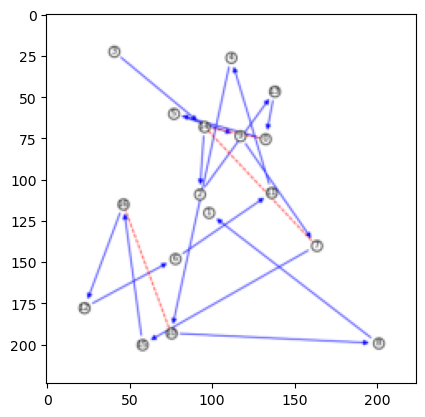

Label: 1


In [8]:
import config.cfg_deit as cfg
from torchvision import datasets, transforms
from src.data_loader import load_data

# image_size = cfg.image_size
image_size = (224, 224)
# batch_size = cfg.batch_size
batch_size = 4
train_ratio = cfg.train_ratio

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

data_path = cfg.DATA_DIR

input_shape = (3, image_size[0], image_size[1])

train_loader, test_loader = load_data(
    data_path=data_path,
    batch_size=batch_size,
    transform=transform,
    train_ratio=train_ratio,
    image_size=image_size, num_workers=0,
)

# --- Check DataLoader ---
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

img = img.permute(1, 2, 0).cpu().numpy()

import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()
print(f"Label: {label}")


In [9]:
import torch.nn as nn
import torch.nn.functional as F
# model_deit = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

# # Changing the last layer to have 2 classes
# in_features = model_deit.head.in_features
# model_deit.head = nn.Linear(in_features, 2)

# print(torch.hub.get_dir())

import timm
model_deit = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=2)

In [10]:

from torch.utils.data import Dataset, DataLoader, TensorDataset

def precompute_deit_tiny_features(model, dataloader):
    model.eval()
    model.to(device)
    list_outputs = []
    list_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            features = model.forward_features(inputs)
            list_outputs.append(features)
            list_labels.append(labels)

    outputs = torch.cat(list_outputs, dim=0)
    labels = torch.cat(list_labels, dim=0)

    return TensorDataset(outputs, labels)

new_train_dataset = precompute_deit_tiny_features(model_deit, train_loader)
new_test_dataset = precompute_deit_tiny_features(model_deit, test_loader)

train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# --- Check DataLoader ---
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

Feature batch shape: torch.Size([4, 197, 192])
Labels batch shape: torch.Size([4])


In [11]:
def train_model(model, dataloader, epochs):
    # Set the model to training mode
    model.train()
    model.to(device)

    # Define the optimizer and the loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')



In [12]:
# Training and testing loop
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training parameters
num_epochs = 20             # Number of epochs (adjust as needed)
learning_rate = 0.001       # Learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deit.head.parameters(), lr=learning_rate)

# Lists to track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1_scores = []

# Training loop
for epoch in range(num_epochs):
    # === Training Phase ===
    model_deit.head.train()
    running_loss, correct_preds, total = 0.0, 0, 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        # Select the CLS token (first token) for classification
        cls_features = features[:, 0, :]

        optimizer.zero_grad()
        outputs = model_deit.head(cls_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct_preds / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === Validation Phase ===
    model_deit.head.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            cls_features = features[:, 0, :]
            outputs = model_deit.head(cls_features)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)

            all_val_preds.append(preds.cpu())
            all_val_labels.append(labels.cpu())

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Compute the F1-score on the validation set (binary average for 2 classes)
    all_val_preds = torch.cat(all_val_preds).numpy()
    all_val_labels = torch.cat(all_val_labels).numpy()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

print("Training completed!")



# === Final Evaluation on the Test Set ===
model_deit.head.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        cls_features = features[:, 0, :]
        outputs = model_deit.head(cls_features)
        preds = torch.argmax(outputs, dim=1)
        all_test_preds.append(preds.cpu())
        all_test_labels.append(labels.cpu())

all_test_preds = torch.cat(all_test_preds).numpy()
all_test_labels = torch.cat(all_test_labels).numpy()


Epoch 1/20 | Train Loss: 0.8426 | Train Acc: 47.92% | Val Loss: 0.7135 | Val Acc: 50.00%
Epoch 2/20 | Train Loss: 0.7599 | Train Acc: 45.83% | Val Loss: 0.6788 | Val Acc: 58.33%
Epoch 3/20 | Train Loss: 0.6999 | Train Acc: 45.83% | Val Loss: 0.7269 | Val Acc: 41.67%
Epoch 4/20 | Train Loss: 0.6638 | Train Acc: 56.25% | Val Loss: 0.6893 | Val Acc: 58.33%
Epoch 5/20 | Train Loss: 0.6502 | Train Acc: 64.58% | Val Loss: 0.6894 | Val Acc: 66.67%
Epoch 6/20 | Train Loss: 0.6405 | Train Acc: 64.58% | Val Loss: 0.6666 | Val Acc: 58.33%
Epoch 7/20 | Train Loss: 0.6146 | Train Acc: 64.58% | Val Loss: 0.7152 | Val Acc: 50.00%
Epoch 8/20 | Train Loss: 0.6212 | Train Acc: 64.58% | Val Loss: 0.6754 | Val Acc: 58.33%
Epoch 9/20 | Train Loss: 0.6008 | Train Acc: 68.75% | Val Loss: 0.6828 | Val Acc: 75.00%
Epoch 10/20 | Train Loss: 0.5715 | Train Acc: 70.83% | Val Loss: 0.6707 | Val Acc: 50.00%
Epoch 11/20 | Train Loss: 0.5792 | Train Acc: 68.75% | Val Loss: 0.6683 | Val Acc: 58.33%
Epoch 12/20 | Train